# 3 — Performance, Validation and Model Interpretation

[Course Notebook on Github](https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb)
### Notes
My goal is not to copy what it is taught in the course and in the notebook. Its just various notes and trying things for my own.

In [1]:
# import
%load_ext autoreload
%autoreload 2


%matplotlib inline
# libs
import os
import pandas as pd
import numpy as np
import re, time
from sklearn.ensemble import RandomForestRegressor

from fastai.imports import *
from fastai.structured import *

In [12]:
import feather

In [13]:
PATH = './datasets/bluebook_bulldozers/'
df_raw = feather.read_dataframe('tmp/bulldozers-raw')

df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

**NOTE** %PRUN profile which things runs the slowest

In [14]:
set_plot_sizes(12,14,16)

In [15]:
def split_vals(a, n): return a[:n], a[n:]
n_valid = 1200
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [16]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [17]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


## Confidence based on tree variance

In [18]:
set_rf_samples(50000)

In [20]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 51 s, sys: 1.19 s, total: 52.2 s
Wall time: 7.67 s
[0.20664759991803303, 0.24801914761564148, 0.9111792940723042, 0.8706737901057631, 0.8945021372891611]


In [23]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 127 ms, sys: 111 µs, total: 127 ms
Wall time: 126 ms


(9.537848035740524, 0.1475137014812125)

In [24]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 74.9 ms, sys: 148 ms, total: 223 ms
Wall time: 238 ms


(9.537848035740524, 0.1475137014812125)

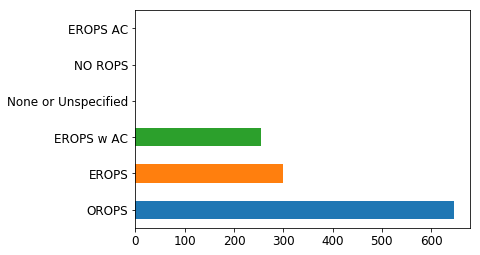

In [25]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [26]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.695435,9.730757,0.256827
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.548809,10.523493,0.267299
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.488561,9.493509,0.216237


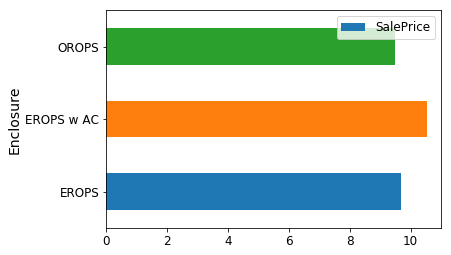

In [27]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

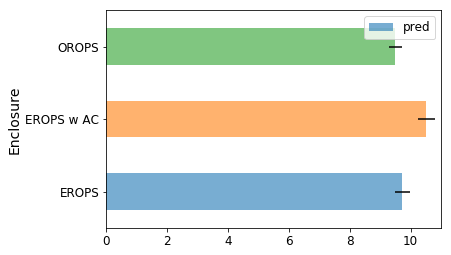

In [28]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

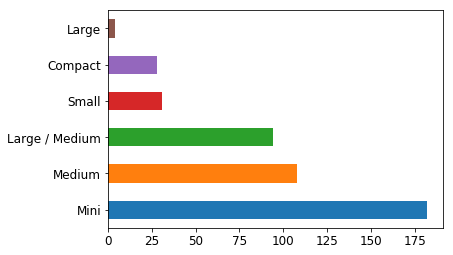

In [29]:
raw_valid.ProductSize.value_counts().plot.barh();

In [31]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.984966,10.032016,0.355489
Large,10.079401,10.193034,0.391588
Large / Medium,10.799444,10.838440,0.271423
Medium,10.755786,10.658902,0.322747
Mini,9.503647,9.541303,0.234061
Small,10.134076,10.247826,0.349065


In [32]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Large             0.038417
Compact           0.035435
Small             0.034062
Medium            0.030280
Large / Medium    0.025043
Mini              0.024531
dtype: float64

### Feature Importance

In [33]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.172239
13,ProductSize,0.101854
37,Coupler_System,0.092782
14,fiProductClassDesc,0.078627
2,ModelID,0.053977
63,saleElapsed,0.050418
38,Grouser_Tracks,0.047222
10,fiSecondaryDesc,0.045115
19,Enclosure,0.043259
39,Hydraulics_Flow,0.042633


In [36]:
??rf_feat_importance

Signature: rf_feat_importance(m, df)
Source:   
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
File:      ~/Code/projects/dsml-learning/Intro_ML_Coders/fastai/structured.py
Type:      function


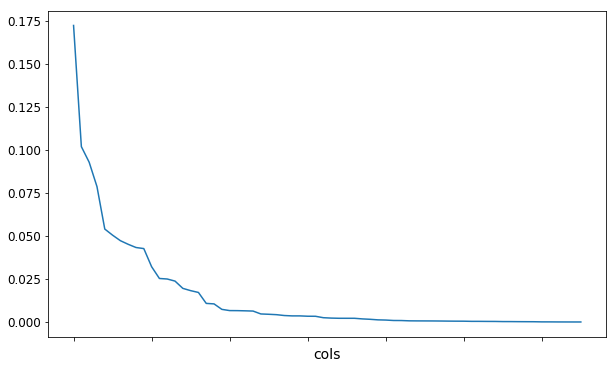

In [37]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [38]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

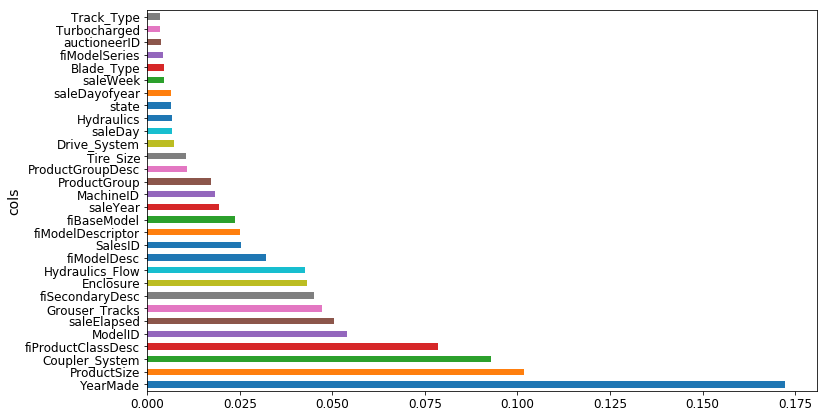

In [39]:
plot_fi(fi[:30]);

In [40]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [41]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [44]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20704165536094607, 0.24473494888801844, 0.9108402274335021, 0.8740761151412487, 0.8949327608923535]


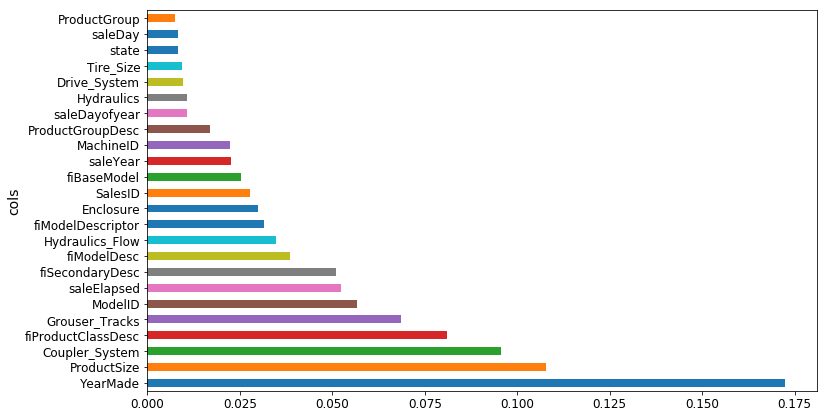

In [45]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);